# OVモデル

In [1]:
import numpy as np
import pathfollowing as pf
import numpy.random as rd
from scipy.integrate import ode, solve_ivp
from scipy.linalg import solve, eigvals
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set('poster', 'whitegrid', 'dark', rc={"lines.linewidth": 2, 'grid.linestyle': '-'})

In [2]:
Ncars = 10

def V(x):
    return np.tanh(x - 2) + np.tanh(2)

def dV(x):
    return 1.0 / np.cosh(x-2)**2

def OV(t, x, a):
    y = np.zeros(2*(Ncars-1))
    for k in range(Ncars-2):
        y[2*k] = x[2*k+1]
        y[2*k+1] = V(x[2*(k+1)]) - V(x[2*k]) - x[2*k+1]
    y[-2] = x[-1]
    y[-1] = V(a - np.sum([x[::2]])) - V(x[-2]) - x[-1]
    return y

def f(x, a):
    y = np.zeros(2*(Ncars-1))
    for k in range(Ncars-2):
        y[2*k] = x[2*k+1]
        y[2*k+1] = V(x[2*(k+1)]) - V(x[2*k]) - x[2*k+1]
    y[-2] = x[-1]
    y[-1] = V(a[0] - np.sum([x[::2]])) - V(x[-2]) - x[-1]
    return y

def fx(x, a):
    A = np.zeros((2*(Ncars-1), 2*(Ncars-1)))
    for k in range(Ncars - 2):
        A[2*k, 2*k+1] = 1.0
        A[2*k+1, 2*k] = -dV(x[2*k])
        A[2*k+1, 2*k+1] = -1.0
        A[2*k+1, 2*(k+1)] = dV(x[2*(k+1)])
    A[-2, -1] = 1.0
    A[-1, ::2] = -dV(a[0] - np.sum([x[::2]]))
    A[-1, -2] += -dV(x[-2])
    A[-1, -1] = -1.0
    return A

def fa(x, a):
    y = np.zeros(2*(Ncars-1))
    y[-1] = dV(a[0] - np.sum([x[::2]]))
    return y

In [3]:
Npts = 64
def func(x, a):
    T = x[-1]
    h = 1.0 / Npts
    n = (len(x) - 1) // Npts
    ss = np.sin([2*np.pi*j*h for j in range(Npts)])
    y = np.zeros(len(x))
    # tau_0 = 0
    y[:n] = (x[n:2*n] - x[(Npts-1)*n:Npts*n])*0.5/h - T * f(x[:n], a)
    # tau_1 ... tau_{N-2}
    for j in range(1, Npts-1):
        y[j*n:(j+1)*n] = (x[(j+1)*n:(j+2)*n] - x[(j-1)*n:j*n])*0.5/h - T * f(x[j*n:(j+1)*n], a)
    # tau_{N-1} = (N-1) * h
    y[(Npts-1)*n:Npts*n] = (x[:n] - x[(Npts-2)*n:(Npts-1)*n])*0.5/h - T * f(x[(Npts-1)*n:Npts*n], a)
    # Phase condition
    y[-1] = x[:-1:n] @ ss
    return y

def dfdx(x, a):
    T = x[-1]
    n = (len(x)-1) // Npts
    h = 1.0 / Npts
    A = np.zeros((len(x), len(x)))
    I = np.identity(n)
    # j = 0
    A[:n, n:2*n] += I * 0.5 / h
    A[:n, (Npts-1)*n:Npts*n] -= I * 0.5 / h
    A[:n,:n] += -T * fx(x[:n], a)
    A[:n,-1] += -f(x[:n], a)
    # j = 1 ... N-2
    for j in range(1, Npts-1):
        A[j*n:(j+1)*n, (j+1)*n:(j+2)*n] += I * 0.5 / h
        A[j*n:(j+1)*n, (j-1)*n:j*n] -= I * 0.5 / h
        A[j*n:(j+1)*n, j*n:(j+1)*n] += -T * fx(x[j*n:(j+1)*n], a)
        A[j*n:(j+1)*n, -1] = -f(x[j*n:(j+1)*n], a)
    # j = N - 1
    A[(Npts-1)*n:Npts*n, :n] += I * 0.5 / h
    A[(Npts-1)*n:Npts*n, (Npts-2)*n:(Npts-1)*n] -= I * 0.5 / h
    A[(Npts-1)*n:Npts*n, (Npts-1)*n:Npts*n] += -T*fx(x[(Npts-1)*n:Npts*n], a)
    A[(Npts-1)*n:Npts*n, -1] += -f(x[(Npts-1)*n:Npts*n], a)
    # Phase condition
    A[-1, :-1:n] = np.sin([2*np.pi*j*h for j in range(Npts)])
    return A

def dfda(x, a):
    T = x[-1]
    n = (len(x) - 1) // Npts
    h = 1.0 / Npts
    b = np.zeros(len(x))
    for j in range(Npts):
        b[j*n:(j+1)*n] = -T*fa(x[j*n:(j+1)*n], a)
    return b

一様交通流の追跡

In [4]:
a=np.array([1.0])
x=np.array([a[0] / Ncars if m%2==0 else 0.0 for m in range(2*(Ncars-1))])
f(x,a)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [5]:
a=np.array([1.0])
x=np.array([a[0] / Ncars if m%2==0 else 0.0 for m in range(2*(Ncars-1))])
bd,bp,lp,hb=pf.pathfollow(x, a, f, fx, fa, nmax=50, h=1.0, epsr=1.0e-10, epsb=1.0e-10, problem='equilibria', quiet=True)

In [6]:
print(hb)
print(bd[-1]['a'])

[12, 16, 28, 32]
[48.89131426]


In [7]:
bd_r = np.array([bd[m]['a'][0] for m in range(len(bd))])
bd_x = np.array([bd[m]['x'][0] for m in range(len(bd))])

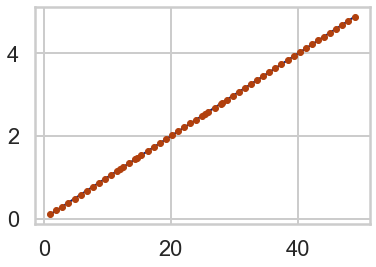

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(bd_r, bd_r/Ncars)
ax.plot(bd_r, bd_x, '.')

渋滞流への追跡の切り替え

In [9]:
vr = bd[hb[0]]['vr']
vi = bd[hb[0]]['vi']
vr /= np.sqrt(vr@vr)
vi /= np.sqrt(vi@vi)
rr = np.hypot(vr, vi)
tt = np.array([np.angle(vr[i]+1.j*vi[i]) for i in range(len(vr))])
ev = eigvals(fx(bd[hb[0]+1]['x'], bd[hb[0]+1]['a']))

In [10]:
ev

array([ 0.00599689+0.3462406j ,  0.00599689-0.3462406j ,
       -0.0375592 +0.61299556j, -0.0375592 -0.61299556j,
       -0.14929177+0.80829059j, -0.14929177-0.80829059j,
       -0.31151055+0.9294773j , -0.31151055-0.9294773j ,
       -0.5       +0.97069536j, -0.5       -0.97069536j,
       -0.68848945+0.9294773j , -0.68848945-0.9294773j ,
       -0.85070823+0.80829059j, -0.85070823-0.80829059j,
       -0.9624408 +0.61299556j, -0.9624408 -0.61299556j,
       -1.00599689+0.3462406j , -1.00599689-0.3462406j ])

In [11]:
ndim = 2*(Ncars-1)
x = np.zeros(ndim*Npts+1)
da = np.abs(bd[hb[0]]['a'][0] - bd[hb[0]+1]['a'][0])
for j in range(Npts):
    x[ndim*j:ndim*(j+1)] = bd[hb[0]+1]['x'] + 10 * np.sqrt(da) * rr * np.cos(2*np.pi*j/Npts + tt - tt[0])
x[-1] = 2*np.pi/np.imag(ev[0])

In [12]:
y = np.copy(x)
a = bd[hb[0]+1]['a']
for m in range(10):
    b = func(y, a)
    A = dfdx(y, a)
    y -= solve(A, b)
    print(np.linalg.norm(b))
# x = np.copy(y)
print(y)

227.27766704752872
129.16442819858497
18.24059643041813
1.6893587392218044
0.0359003496082432
1.7101534471879468e-05
4.28301792683525e-12
1.2826154611482426e-13
1.0209239286996085e-13
1.186202405464889e-13
[3.31242175e+00 1.67448641e-02 2.39836298e+00 ... 7.81296637e-01
 6.19678563e-01 1.75678008e+01]


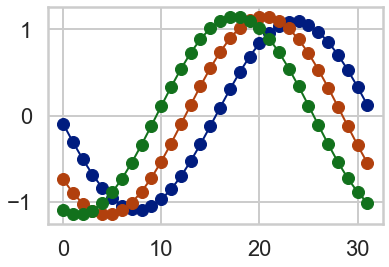

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x[1:-1:2*ndim],'o-')
ax.plot(x[3:-1:2*ndim],'o-')
ax.plot(x[5:-1:2*ndim],'o-')

In [14]:
x = np.copy(y)
bdc=pf.pathfollow00(x, a, func, dfdx, dfda, nmax=100, h=1.0, epsr=1.0e-10, epsb=1.0e-10)

# TY a x
R 12.708549661388064 3.3438164358058398
R 12.928966384532444 3.3716859821948053
R 13.154121232838587 3.396471923082832
R 13.383172706277197 3.418567790569729
R 13.61544179190947 3.4383174894435387
R 13.850378828088326 3.4560185416601588
R 14.08753699157525 3.471928077831348
R 14.326551356284735 3.486269412734178
R 14.567122422425358 3.4992373636869516
R 14.809003172591261 3.5110014197120645
R 15.051988907832753 3.521707161154763
R 15.295909247472204 3.531477310934275
R 15.540621779201315 3.5404139055728003
R 15.78600698097145 3.5486022445866765
R 16.03196415948707 3.556116010017632
R 16.278408197320307 3.56302199445637
R 16.525266911537724 3.569382805734309
R 16.77247887752544 3.575256810451824
R 17.019991642415672 3.580695969262655
R 17.267760270425363 3.585743320023729
R 17.515746137935817 3.5904320257426994
R 17.763915905301364 3.594787003180451
R 18.012240642263578 3.5988286789640713
R 18.26069510358412 3.6025771910522026
R 18.509257120867158 3.6060550316512097
R 18.757907

In [15]:
bdc_r = np.array([bdc[m]['a'][0] for m in range(len(bdc))])
bdc_xmax = np.array([np.max(bdc[m]['x'][:-1:2*ndim]) for m in range(len(bdc))])
bdc_xmin = np.array([np.min(bdc[m]['x'][:-1:2*ndim]) for m in range(len(bdc))])

In [16]:
x = np.copy(y)
bdc2=pf.pathfollow00(x, a, func, dfdx, dfda, nmax=50, h=-1.0, epsr=1.0e-10, epsb=1.0e-10)

# TY a x
R 12.286363867785383 3.2770222665024837
R 12.08748405019737 3.2371166792866015
R 11.899214193923575 3.19221837659411
R 11.723856055635945 3.1419084772842854
R 11.564038188301637 3.0859111207801937
R 11.422580963121616 3.0241836691898394
R 11.302228268439018 2.9570005791454443
R 11.205255265565459 2.884994999441965
R 11.13304363973707 2.809121841263116
R 11.085783452674155 2.7305338220634945
R 11.06243448759242 2.6504078002246705
R 11.060952508918861 2.5697856811950945
R 11.078659715116421 2.4894780707222233
R 11.112610461974935 2.410038631325939
R 11.159861209368032 2.3317876992650257
R 11.217625517394364 2.254857752189831
R 11.283336286357398 2.1792413992905333
R 11.354647492179904 2.1048327181593907
R 11.42940191737311 2.0314596486847614
R 11.505581953736833 1.9589085163830038
R 11.58125272289356 1.8869429525991073
R 11.65450171739797 1.8153197456201162
R 11.723376880107637 1.7438042803163938
R 11.78582619501316 1.6721887241113513
R 11.839650107443822 1.6003175585482539
R 11

In [17]:
bdc2_r = np.array([pt['a'][0] for pt in bdc2])
bdc2_xmax = np.array([np.max(pt['x'][:-1:2*ndim]) for pt in bdc2])
bdc2_xmin = np.array([np.min(pt['x'][:-1:2*ndim]) for pt in bdc2])

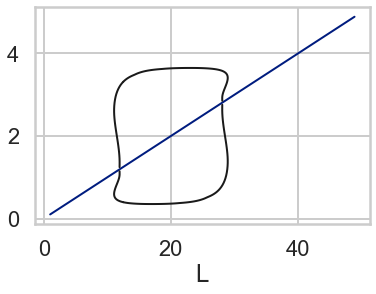

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("L")
ax.plot(bd_r, bd_x, '-')
ax.plot(bdc_r[:93], bdc_xmax[:93], '-k')
ax.plot(bdc_r[:93], bdc_xmin[:93], '-k')
ax.plot(bdc2_r[:31], bdc2_xmax[:31], '-k')
ax.plot(bdc2_r[:31], bdc2_xmin[:31], '-k')

一様交通流から別の渋滞流に切り替える

In [19]:
vr = bd[hb[1]]['vr']
vi = bd[hb[1]]['vi']
vr /= np.sqrt(vr@vr)
vi /= np.sqrt(vi@vi)
rr = np.hypot(vr, vi)
tt = np.array([np.angle(vr[i]+1.j*vi[i]) for i in range(len(vr))])
ev = eigvals(fx(bd[hb[1]+1]['x'], bd[hb[1]+1]['a']))

In [20]:
ev

array([ 0.03935514+0.44285787j,  0.03935514-0.44285787j,
        0.01078902+0.75663299j,  0.01078902-0.75663299j,
       -0.10721763+0.98395411j, -0.10721763-0.98395411j,
       -0.28765862+1.12487577j, -0.28765862-1.12487577j,
       -0.5       +1.17280679j, -0.5       -1.17280679j,
       -0.71234138+1.12487577j, -0.71234138-1.12487577j,
       -0.89278237+0.98395411j, -0.89278237-0.98395411j,
       -1.01078902+0.75663299j, -1.01078902-0.75663299j,
       -1.03935514+0.44285787j, -1.03935514-0.44285787j])

In [21]:
ndim = 2*(Ncars-1)
x = np.zeros(ndim*Npts+1)
da = np.abs(bd[hb[1]]['a'][0] - bd[hb[1]+1]['a'][0])
for j in range(Npts):
    x[ndim*j:ndim*(j+1)] = bd[hb[1]+1]['x'] + 10 * np.sqrt(da) * rr * np.cos(2*np.pi*j/Npts + tt - tt[0])
x[-1] = 2*np.pi/np.imag(ev[2])

In [22]:
y = np.copy(x)
a = bd[hb[1]+1]['a']
for m in range(10):
    b = func(y, a)
    A = dfdx(y, a)
    y -= solve(A, b)
    print(np.linalg.norm(b))
# x = np.copy(y)
print(y)

221.671066177723
38.75506909384654
9.492401839045918
2.834377457394159
0.3840407945628004
0.012361561168604063
1.561331546138094e-05
2.3333085740644462e-11
1.2146450965404943e-13
1.1525803096437134e-13
[ 2.18171565 -0.06179968  1.64889586 ...  1.02953799  0.11269814
  8.37710252]


In [23]:
x = np.copy(y)
bdc3=pf.pathfollow00(x, a, func, dfdx, dfda, nmax=100, h=1.0, epsr=1.0e-10, epsb=1.0e-10)

# TY a x
R 15.479795715277916 2.242487310871312
R 15.604761308343631 2.3037879155139023
R 15.743785447658283 2.365519463502451
R 15.898413922898849 2.427522062616748
R 16.070143566987824 2.4895574367865914
R 16.260288561045023 2.551296478615954
R 16.46982106403574 2.6123157299616686
R 16.699209156915394 2.6721081456358116
R 16.948290013269297 2.730111442404906
R 17.216219996699994 2.7857521449147766
R 17.50152680308135 2.838496792611115
R 17.80225490813407 2.887897568062669
R 18.11616253487907 2.9336211033567934
R 18.44091575309281 2.9754557792379317
R 18.774237400286516 3.0133002830952353
R 19.113992933493094 3.0471405943782104
R 19.458216662313777 3.0770229794562898
R 19.805092764904618 3.1030285342452006
R 20.15290730131376 3.1252522734495405
R 20.499984764893888 3.143787870303981
R 20.844619578333603 3.158718156309916
R 21.185011564304244 3.1701111820325685
R 21.5192154932498 3.1780216647633623
R 21.84511779015781 3.182497647301732
R 22.16045636602878 3.183591831356231
R 22.4628985

In [24]:
bdc3_r = np.array([bdc3[m]['a'][0] for m in range(len(bdc3))])
bdc3_xmax = np.array([np.max(bdc3[m]['x'][:-1:2*ndim]) for m in range(len(bdc3))])
bdc3_xmin = np.array([np.min(bdc3[m]['x'][:-1:2*ndim]) for m in range(len(bdc3))])

In [25]:
x = np.copy(y)
bdc4=pf.pathfollow00(x, a, func, dfdx, dfda, nmax=50, h=-1.0, epsr=1.0e-10, epsb=1.0e-10)

# TY a x
R 15.266182304159859 2.1215254683708014
R 15.17495465295698 2.061942597852163
R 15.092699864255659 2.0029778100725113
R 15.018620902727678 1.9446408384243439
R 14.952146841298282 1.8869519061602082
R 14.892938435406753 1.8299520119460102
R 14.840885759690321 1.7737117777063174
R 14.796093655983576 1.7183381293914384
R 14.75884926387541 1.66397742245762
R 14.729566603455954 1.6108130742568296
R 14.708707533368191 1.5590557767262059
R 14.696686933268749 1.5089255060583615
R 14.693780346223567 1.4606270593697634
R 14.700058734811721 1.4143239813502462
R 14.715371158008356 1.3701176627653655
R 14.73938132795558 1.32803738051343
R 14.771645704783905 1.288043243160415
R 14.811709479155946 1.2500396203198485
R 14.859197206429176 1.2138940875860889
R 14.91388356376031 1.179456958151343
R 14.975739930760861 1.1465781598948601
R 15.044959575765315 1.115120187124103
R 15.121967091604418 1.084967279061345
R 15.207417445921998 1.05603168107855
R 15.302188070433758 1.0282580069259948
R 15.4

In [26]:
bdc4_r = np.array([pt['a'][0] for pt in bdc4])
bdc4_xmax = np.array([np.max(pt['x'][:-1:2*ndim]) for pt in bdc4])
bdc4_xmin = np.array([np.min(pt['x'][:-1:2*ndim]) for pt in bdc4])

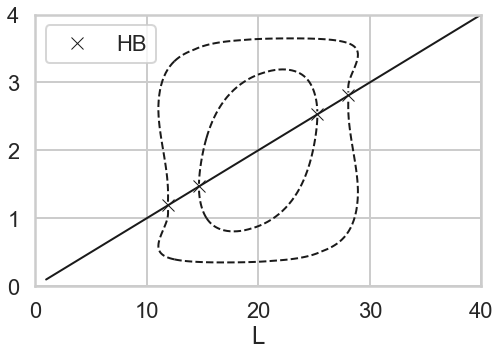

In [27]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.set_xlim(0, 40)
ax.set_ylim(0,4)
ax.set_xlabel("L")
ax.plot(bd_r, bd_x, '-k')
ax.plot(bd_r[hb], bd_x[hb], 'xk', label="HB")
ax.plot(bdc_r[:93], bdc_xmax[:93], '--k')
ax.plot(bdc_r[:93], bdc_xmin[:93], '--k')
ax.plot(bdc2_r[:31], bdc2_xmax[:31], '--k')
ax.plot(bdc2_r[:31], bdc2_xmin[:31], '--k')
ax.plot(bdc3_r[:50], bdc3_xmax[:50], '--k')
ax.plot(bdc3_r[:50], bdc3_xmin[:50], '--k')
ax.plot(bdc4_r[:13], bdc4_xmax[:13], '--k')
ax.plot(bdc4_r[:13], bdc4_xmin[:13], '--k')
ax.legend()
# plt.savefig("bd_OV.pdf", bbox_inches='tight')